In [1]:
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Insure that all columns and rows are displayed 
pd.options.display.max_columns = None
# pd.set_option('display.max_colwidth', None)

In [3]:
# start = time.time()
# accepted_df = pd.read_csv('../accepted_2007_to_2018Q4.csv.gz', low_memory=False)
# rejected_df = pd.read_csv('../rejected_2007_to_2018Q4.csv.gz', low_memory=False)
# feat_def = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
# print(accepted_df.shape)
# print(f"Reading the csv's take {round(time.time() - start)} seconds")
# accepted_df.head()

First I will limit the dataset to loans that have defualted or have been fully paid since that is what I'm looking to predict.

In [4]:
# accepted_df.loan_status.value_counts()

In [5]:
# # only keep the loans that are paid or charged off.
# accepted_df = accepted_df[accepted_df.loan_status.isin(['Fully Paid', 'Charged Off'])]
# accepted_df.shape

Just from that we dropped about a million loans. 

We need to check how much of these columns have missing values. If a variable has a high proportion of NaN's, that makes it very hard to know if the values that you do have are the true distribution. So I will drop any column that has more than 30% NaN's.

In [6]:
# accepted_df.isna().sum()

In [7]:
# # get a list of the column names that have more than 30% missing values, and drop those columns
# thirty_nan = [i for i in accepted_df.columns if accepted_df[i].isnull().sum() > 0.3*accepted_df.shape[0]]
# print('Droping ', len(thirty_nan), ' columns')
# accepted_df.drop(thirty_nan, axis=1, inplace=True)
# accepted_df.shape

We still have 93 columns, and most of those either aren't available to the investor at the time of investment, or are not relevant to the prediction. So I will start with keeping the most basic features, and if I can't get good results from my prediction, I will try to add some more features. Here's a look at the descriptions of each feature in the dataset.

In [8]:
# feat_def

In [9]:
# # basic features to start with.
# # I will keep the zip code and date features as well for further anaylsis, even though I won't use it for the prediction.
# keep_list=['term', 'int_rate', 'grade', 'dti','loan_status', 'emp_length', 'loan_amnt', 
#            'annual_inc', 'application_type','home_ownership', 'issue_d', 'zip_code']
# accepted_df = accepted_df[keep_list].copy()
# accepted_df.shape

In [10]:
# # now check how many NaN's there are in each of the remaining columns
# accepted_df.isna().sum()

For "dti" and "zip_code" we'll just drop those rows since the're so few.

Employment length has a lot of NaN's. Let's check if there's a way around dropping those values.

In [11]:
# # check the proportion for each value
# accepted_df.emp_length.value_counts().sort_index()

In [12]:
# # check what percentage of loans for each emp_length are charged off.
# (accepted_df.groupby(['emp_length', 'loan_status']).size().unstack(fill_value=0)['Charged Off'].sort_index() / 
# accepted_df.emp_length.value_counts().sort_index())

In [13]:
# # check the total class balance
# accepted_df.loan_status.value_counts(normalize=True)

In [14]:
# # check the percentage of charged off from all the loans with missing values in emp_length
# accepted_df[accepted_df.emp_length.isna() == True]['loan_status'].value_counts(normalize=True)

We see the proportion for charged off loans for each employee length is basically consistent in each value, which may imply that it is not a impactfull feature. But it's very curious that from the loans that have missing values for emp_length have a much higher charged off rate. I'll see if I can make sense of that.

In [15]:
# emp_nan = accepted_df[accepted_df.emp_length.isna() == True]
# no_nan = accepted_df.dropna()

In [16]:
# # check the distribution for income with the nan's
# emp_nan.annual_inc.hist(log=True);

In [17]:
# # the distribution doesn't seem to be very different
# no_nan.annual_inc.hist(log=True);

In [18]:
# # check the proportion of longer or shorter term loans for both subsets
# print("Proportion with the nans")
# print(emp_nan.term.value_counts(normalize=True))
# print("")
# print("Proportion without the nans")
# print(no_nan.term.value_counts(normalize=True))

This might be a contributer. The subset with more charged off loans has a lower proportion of 60 months loans. Let's see if the longer loans have fewer charged off.

In [19]:
# accepted_df.groupby(['term', 'loan_status']).size().unstack()

It seems to be the opposite, longer loans have a much higher charged off rate. 

I can't think of any accurate way to fill in the missing values, and either way the emp_length doesn't seem to be a major factor, so I will just drop that column. I am more confident doing this since we have the annual income anyway which is the more telling feature.

In [20]:
# accepted_df.dropna(subset=['zip_code', 'dti', 'emp_length'], inplace=True)
# accepted_df.info()

The dataframe is still 116 MB. I would like to shrink it down to at least 50 MB so that it is easier to run it through a classifiying algorithm. I'll take the loans from the last few years. Hopefully that won't weaken the model.

In [21]:
# accepted_df.issue_d

In [22]:
# # change the issue_d to a datetime object and sort the dataframe by date and change the name to date
# accepted_df['issue_d'] = pd.to_datetime(accepted_df['issue_d'])
# accepted_df.sort_values('issue_d', inplace=True)
# accepted_df.reset_index(drop=True, inplace=True)
# accepted_df.rename(columns={'issue_d': 'date'}, inplace=True)
# # take the loans since 2016
# last_3_yr = accepted_df[accepted_df.date >= '2016-01'].copy()
# last_3_yr.info()

In [23]:
# last_3_yr = accepted_df[accepted_df.date >= '2016-01'].copy()
# last_3_yr.info()

In order to avoid having to read in the whole dataframe each time, I'll save this dataframe to a csv.

In [24]:
# last_3_yr['loan_status'] = last_3_yr.loc[:,'loan_status'].map({'Fully Paid' : 0, 'Charged Off': 1})
# last_3_yr.to_csv('data/accepted_16_to_18.csv', index=False)

I will now do this for the rejected dataset.

In [25]:
# rejected_df

In [26]:
# rejected_df.info()

In [27]:
# rejected_df.isna().sum()

I'm going to use this dataset to compare it with the accepted loans, so I will drop the features that aren't in the accepted loans.

In [28]:
# rejected_df.drop(['Risk_Score', 'Policy Code', 'State', 'Loan Title'], axis=1, inplace=True)
# rejected_df.dropna(inplace=True)

In [29]:
# rejected_df.shape

Now I'll make the date column a datetime object and take the last 3 years again, like I did for the other dataset.

In [30]:
# rejected_df['Application Date'] = pd.to_datetime(rejected_df['Application Date'])
# # rename columns to match the accepted dataframe
# rename_dict = {'Application Date': 'date', 'Amount Requested': 'loan_amnt', 
#                'Debt-To-Income Ratio': 'dti', 'Employment Length': 'emp_length',
#               'Zip Code': 'zip_code'}
# rejected_df.rename(columns=rename_dict, inplace=True)

In [31]:
# last_3_yr_rejected = rejected_df[rejected_df.date >= '2016-01'].sort_values('date').reset_index(drop=True)
# last_3_yr_rejected

In [32]:
# last_3_yr_rejected.info()

This dataframe is still too big to upload to github, but I'll still save this as a csv so I don't need to load the full dataset.

In [33]:
# last_3_yr_rejected.to_csv('data/rejected_16_to_18.csv', index=False)

In [34]:
accepted_df = pd.read_csv('data/accepted_16_to_18.csv')
accepted_df

,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
0,36 months,11.22,B,3.10,0,7 years,5000.0,65000.0,Individual,MORTGAGE,2016-01-01,201xx
1,36 months,9.17,B,20.30,0,10+ years,35000.0,82400.0,Individual,MORTGAGE,2016-01-01,146xx
2,36 months,5.32,A,7.43,0,9 years,20000.0,200000.0,Individual,OWN,2016-01-01,208xx
3,36 months,10.78,B,2.75,0,6 years,6000.0,85000.0,Individual,RENT,2016-01-01,908xx
4,36 months,12.88,C,8.07,1,< 1 year,3725.0,16800.0,Individual,RENT,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482749,36 months,14.47,C,23.76,0,10+ years,7450.0,76000.0,Individual,MORTGAGE,2018-12-01,483xx
482750,36 months,12.98,B,26.50,0,10+ years,9600.0,75000.0,Individual,RENT,2018-12-01,917xx
482751,36 months,7.02,A,16.38,0,< 1 year,20000.0,97000.0,Individual,RENT,2018-12-01,801xx
482752,36 months,15.02,C,11.64,0,< 1 year,10000.0,66000.0,Individual,OWN,2018-12-01,452xx


To explore the data, I'll take a look at how often loans go bad per value of each categorical feature. Then for the numerical features see how they are distributed with the loans get paid and the loans that default.

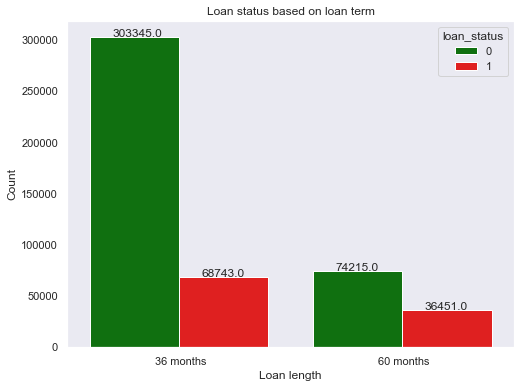

In [189]:
# check the number of defaulted loans per loan term
plt.figure(figsize=(8,6))
sns.set(style="dark")
ax = sns.countplot(x="term", data=accepted_df, hue='loan_status', palette=['green', 'red'])
plt.title('Loan status based on loan term')
plt.xlabel('Loan length')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

We see that longer loans tend to have more trouble getting paid. The reason might be that there is just more time for things to go wrong. Sticking with the shorter loans is the safer bet.

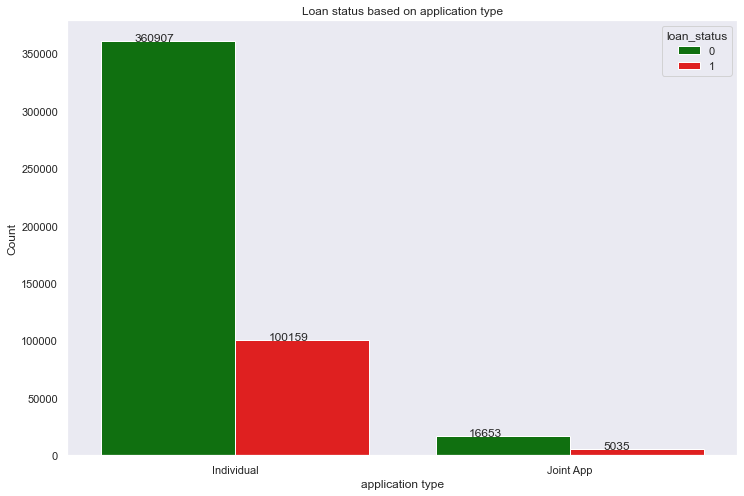

In [145]:
# check the number of defaulted loans per application type
plt.figure(figsize=(12,8))
ax = sns.countplot(x="application_type", data=accepted_df, hue='loan_status', palette=['green', 'red'])
plt.title('Loan status based on application type')
plt.xlabel('application type')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

There are a lot more individual loans than joint ones. However there doesn't seem to be much of a difference in the default rate.

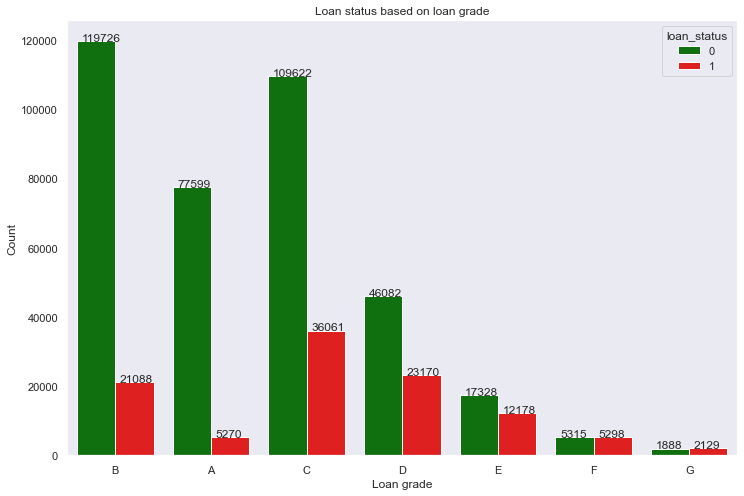

In [146]:
# check the number of defaulted loans per grade
plt.figure(figsize=(12,8))
ax = sns.countplot(x="grade", data=accepted_df, hue='loan_status', palette=['green', 'red'])
plt.title('Loan status based on loan grade')
plt.xlabel('Loan grade')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))

Grade is a score for how secure a loan is, and not surprisingly, the lower the grade, the more loans default. Notice that loans with grade "G" have more defaulted loans than paid loans!

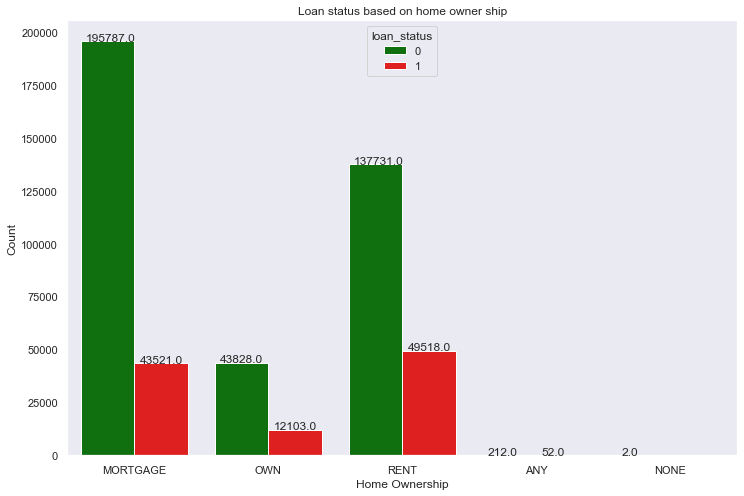

In [147]:
# check the number of defaulted loans per home_ownership
plt.figure(figsize=(12,8))
ax = sns.countplot(x="home_ownership", data=accepted_df, hue='loan_status', palette=['green', 'red'])
plt.title('Loan status based on home owner ship')
plt.xlabel('Home Ownership')
plt.ylabel('Count')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.04, p.get_height()+50))

Again, home owenership type doesn't seem to have to much of an impact.

Now I'll take a look at the numerical values.

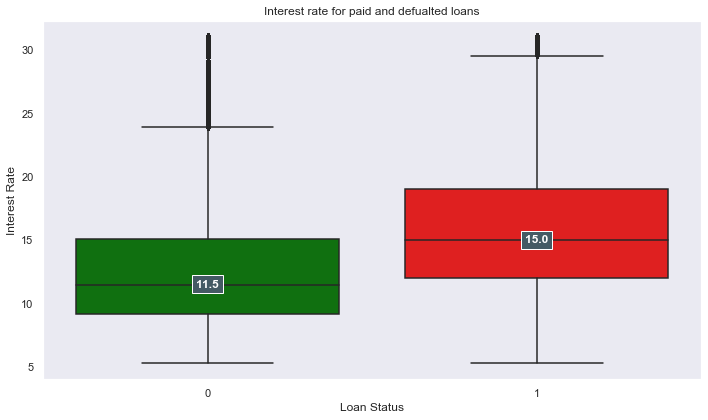

In [183]:
# a boxplot to show the distribution of interest rates on loans that were paid and defaulted.
box_plot = sns.boxplot(x="loan_status", y="int_rate", data=accepted_df, palette=['green', 'red'])
plt.gcf().set_size_inches(10, 6)
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#445A64'))

plt.title('Interest rate for paid and defualted loans')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
box_plot.figure.tight_layout()

It's clear that the loans that charged off, usually had a much higher interest rate. This must be because the riskier loans are the ones that charge off more, and the riskier loans have higher interest rates.
Let's look at the interest rates by loan grade.

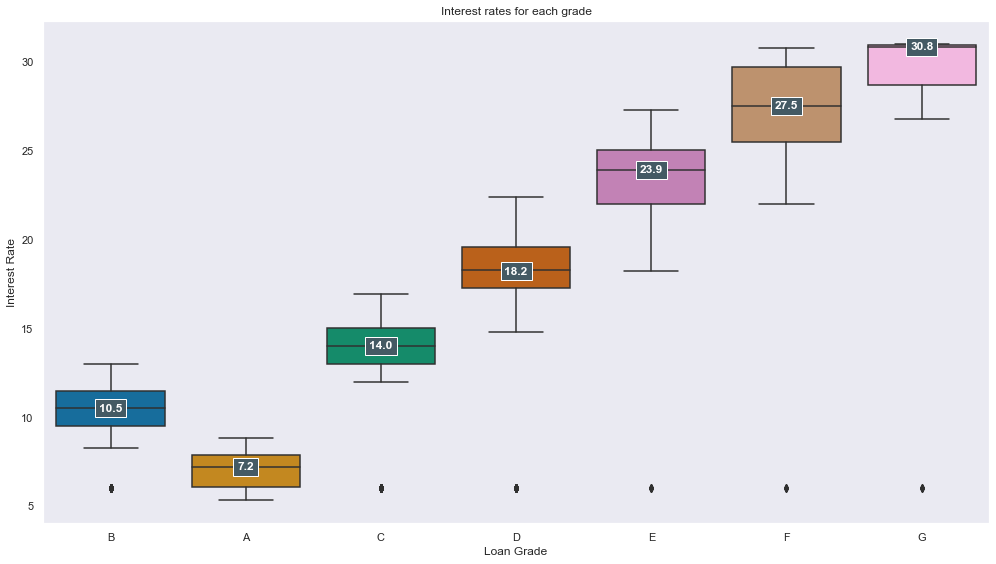

In [187]:
box_plot = sns.boxplot(x="grade", y="int_rate", data=accepted_df, palette='colorblind')
plt.gcf().set_size_inches(14, 8)
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#445A64'))

plt.title('Interest rates for each grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
box_plot.figure.tight_layout()

Just as we thought, lower grade means higher interest.

This gives me an idea for potential value. What if we were able to predict, with reasonable success, which loans will default from the risky loans. In that case we'd be able to get the high interest on our investment without losing too much from the defaulted loans! I am going to shift my focus to that, and see how well I can predict these loans.

I still want to take a look at the other numerical variables.

In [194]:
np.log(accepted_df.annual_inc)

0         11.082143
1         11.319341
2         12.206073
3         11.350407
4          9.729134
            ...    
482749    11.238489
482750    11.225243
482751    11.482466
482752    11.097410
482753    10.596635
Name: annual_inc, Length: 482754, dtype: float64

array([[<AxesSubplot:title={'center':'annual_inc'}>]], dtype=object)

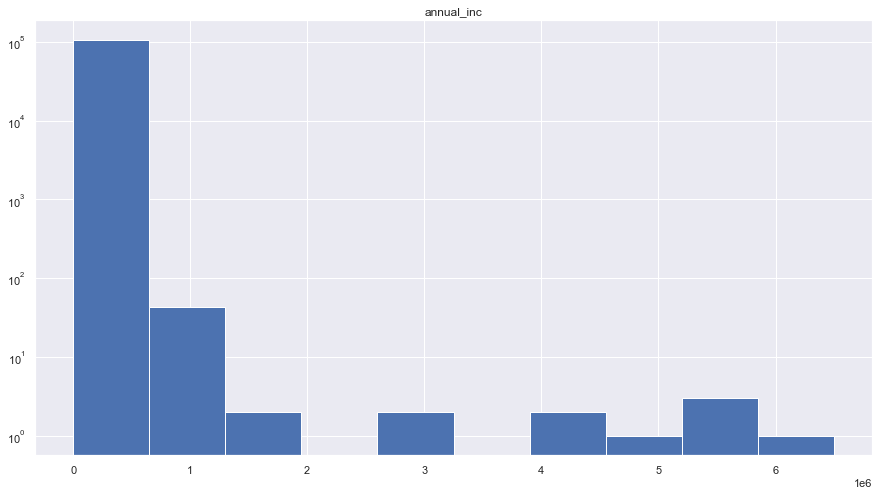

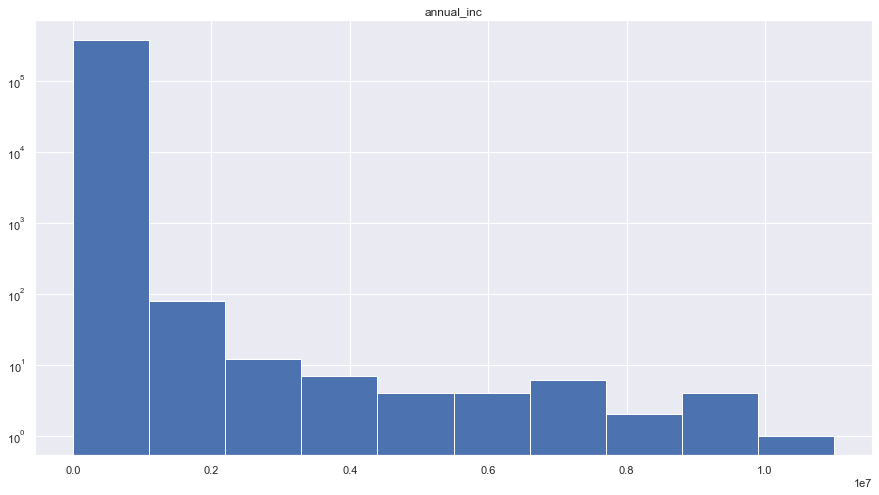

In [203]:
accepted_df[accepted_df.loan_status == 1].hist('annual_inc', log=True)
accepted_df[accepted_df.loan_status == 0].hist('annual_inc', log=True)

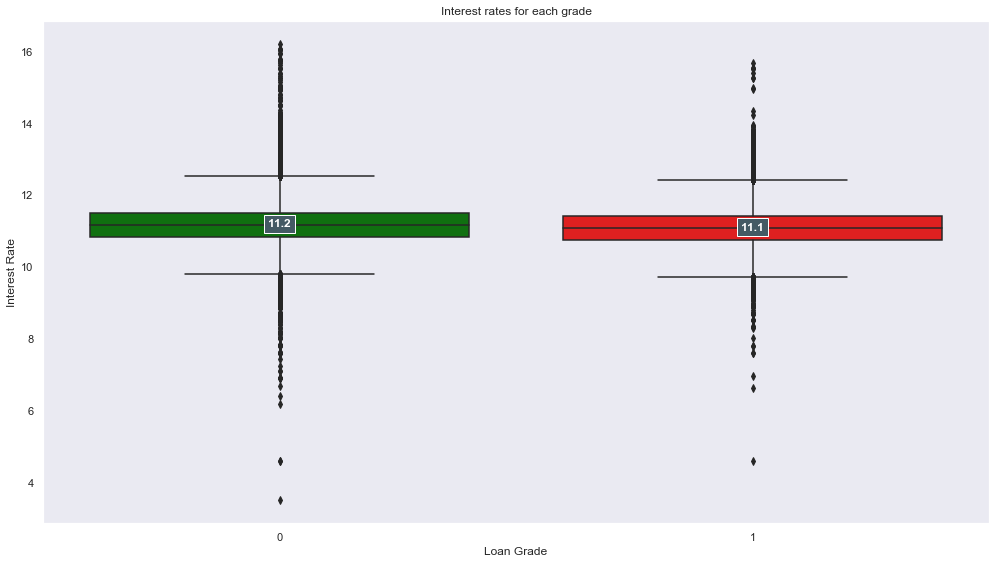

In [195]:
box_plot = sns.boxplot(x="loan_status", y=np.log(accepted_df.annual_inc), data=accepted_df, palette=['green', 'red'])
plt.gcf().set_size_inches(14, 8)
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#445A64'))

plt.title('Interest rates for each grade')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
box_plot.figure.tight_layout()

In [ ]:
# check the number of defaulted loans per loan length

In [37]:
notebook_end = time.time()
print(f'This notebook takes {round(notebook_end - notebook_start)} seconds to run')

This notebook takes 559 seconds to run
